In [180]:
import pandas as pd
import datetime
import random
import pytz

from sqlalchemy import create_engine

from password import hoop_pwd
pwd = hoop_pwd.password

%matplotlib inline

from nba_seer import *

In [181]:
# create sql conn and load game stats logs ----------------------

conn = create_engine('mysql+pymysql://root:%s@118.190.202.87:3306/nba_stats' % pwd)
game_stats_logs = pd.read_sql_table('game_stats_logs', conn)
game_stats_logs = game_stats_logs[game_stats_logs['GAME_TYPE'] != 'all_star']

print(str(len(game_stats_logs)) + ' player stats loaded.')

187359 player stats loaded.


In [182]:
# load player list ----------------------

all_players = nba_py.player.PlayerList(season='2017-18').info()

print('players list loaded')

players list loaded


In [183]:
def get_score(row):
    player_id = row['PERSON_ID']
    game_id = row['GAME_ID']
    stats = game_stats_logs[(game_stats_logs['PLAYER_ID'] == player_id) & 
                            (game_stats_logs['GAME_ID'] == game_id)].copy()
    #print(stats)
    stats['SCO'] = stats['PTS'] * 1 + stats['AST'] * 1.5 + \
    stats['OREB'] * 1 + stats['DREB'] * 0.7 + \
    stats['STL'] * 2 + stats['BLK'] * 1.8 + stats['TO'] * -1 + \
    stats['FGM'] * 0.4 + (stats['FGA'] - stats['FGM']) * -1 + stats['FG3M'] * 0.5
    return stats['SCO'].max()

In [184]:
def test_result(players):
    diff_pct = players['SCO_DIFF_PCT'].describe().to_frame()
    diff_sco = players['SCO_DIFF'].describe().to_frame()
    ans = pd.concat([diff_sco, diff_pct], axis=1)
    return ans

In [185]:
def factor_cov(players):
    cov_diff = pd.DataFrame()
    #cov_diff['cov'] = abs(players[['MIN_COV_20', 'SCO_COV_20']].mean(axis = 1))
    cov_diff['cov'] = abs(players['MIN_COV_20'] * players['SCO_COV_20'])
    cov_diff['diff_pct'] = abs(players['SCO_DIFF_PCT'])
    cov_diff.plot(x='cov', y='diff_pct', kind='scatter', grid=True, figsize=(10, 7))
    cov_diff_pct_corr = cov_diff['cov'].corr(cov_diff['diff_pct'])
    print('the corr between cov and different percantage is: ', cov_diff_pct_corr)

In [186]:
def diff_distribution(players, rg, interval):
    diff_pct = players[abs(players['SCO_DIFF_PCT']) <= rg]['SCO_DIFF_PCT'].abs()
    bins = []
    for i in range(int(rg/interval)):
        bins.append(i*interval)
    pct_cut = pd.cut(diff_pct, bins)
    pct_cut_df = pd.value_counts(pct_cut).to_frame().rename(columns={'SCO_DIFF_PCT': 'count'})
    pct_cut_df = pct_cut_df.sort_index(axis=0)
    pct_cut_df.plot(kind='bar', figsize=(15, 7))
    print('data in range:', len(diff_pct)/len(players))

In [187]:
game_date = game_stats_logs['GAME_DATE_EST'].drop_duplicates().apply(lambda x: x[:10])

In [220]:
players = pd.DataFrame()
for i in random.sample(list(game_date), 5):
    j = datetime.datetime.strptime(i, "%Y-%m-%d").date()
    games = get_games(j)
    players = players.append(get_players_p(games, game_stats_logs))
    print(str(j) + ' complete!')
else:
    print(len(players), ' players total!')

2017-01-15 complete!
2013-04-01 complete!
2014-04-06 complete!
2016-11-19 complete!
2014-12-30 complete!
1103  players total!


In [221]:
players = get_exp_sco(players, game_stats_logs)

5games days complete!
days rest complete!
ma20 complete!
ma10 complete!
ma5 complete!
min20 complete!
min10 complete!
min5 complete!
min_cov_20 complete!
sco_cov_20 complete!
sco cov less than 0 droped!
all done!


In [222]:
players['ACT_SCO'] = players.apply(get_score, axis = 1)
players['SCO_DIFF'] = players['EXP_SCO'] - players['ACT_SCO']
players['SCO_DIFF_PCT'] = players['SCO_DIFF'] / players['ACT_SCO']
print('test data loaded!')

test data loaded!


In [223]:
players = players[(players['ACT_SCO'] != 0) & (players['ACT_SCO'].notnull())]

In [224]:
players.sort_values('ACT_SCO')

,PERSON_ID,TEAM_ID,Location,GAME_ID,Against_Team_ID,5_g_d,d_rest,MA_20,MA_10,MA_5,MIN_20,MIN_10,MIN_5,MIN_COV_20,SCO_COV_20,EXP_SCO,ACT_SCO,SCO_DIFF,SCO_DIFF_PCT
20,203501,1610612752,AWAY,0021301149,1610612748,8,1303,14.66,14.47,13.50,25.95,23.92,25.84,0.264,0.888,9.96,-6.3,16.26,-2.580952
78,201579,1610612754,HOME,0021301152,1610612737,8,1303,14.97,15.15,14.03,29.52,29.25,30.05,0.166,0.528,12.10,-6.0,18.10,-3.016667
18,203498,1610612750,AWAY,0021600608,1610612742,11,288,16.83,20.73,19.45,20.39,22.31,21.83,0.211,0.621,11.35,-5.3,16.65,-3.141509
164,201960,1610612762,HOME,0021201106,1610612757,17,1678,19.61,9.50,14.72,14.72,8.90,3.81,0.656,0.911,3.71,-4.3,8.01,-1.862791
185,203957,1610612762,HOME,0021400472,1610612750,11,1034,12.71,17.22,12.17,17.94,19.28,20.93,0.242,0.913,7.56,-3.5,11.06,-3.160000
36,1627832,1610612761,HOME,0021600606,1610612752,33,288,25.71,15.70,35.17,5.28,8.34,4.15,1.263,1.366,4.20,-3.0,7.20,-2.400000
98,2564,1610612759,AWAY,0021400468,1610612763,10,1035,20.41,21.11,24.26,27.29,27.13,26.73,0.234,0.642,16.48,-2.8,19.28,-6.885714
101,203898,1610612745,AWAY,0021600609,1610612751,16,290,9.05,9.19,17.03,5.70,6.65,1.48,0.953,1.367,1.51,-2.0,3.51,-1.755000
124,203117,1610612753,AWAY,0021201104,1610612745,9,1673,12.41,19.08,19.85,7.06,6.20,6.65,0.536,1.968,3.15,-2.0,5.15,-2.575000
171,203197,1610612762,AWAY,0021301155,1610612744,10,1303,11.13,10.90,7.59,15.74,15.92,16.05,0.293,1.171,4.36,-2.0,6.36,-3.180000


In [247]:
players_t = players[players['5_g_d'] < 20]
players_t = players_t[players_t['SCO_COV_20'] < 0.6]
players_t = players_t[players_t['MIN_COV_20'] < 0.25]
players_t.sort_values('ACT_SCO')

,PERSON_ID,TEAM_ID,Location,GAME_ID,Against_Team_ID,5_g_d,d_rest,MA_20,MA_10,MA_5,MIN_20,MIN_10,MIN_5,MIN_COV_20,SCO_COV_20,EXP_SCO,ACT_SCO,SCO_DIFF,SCO_DIFF_PCT
78,201579,1610612754,HOME,0021301152,1610612737,8,1303,14.97,15.15,14.03,29.52,29.25,30.05,0.166,0.528,12.10,-6.0,18.10,-3.016667
143,201584,1610612763,AWAY,0021301154,1610612759,8,1303,16.76,15.72,22.47,27.34,27.91,30.62,0.208,0.560,14.56,-1.6,16.16,-10.100000
223,101150,1610612761,AWAY,0021400473,1610612757,10,1035,25.53,23.64,27.01,26.40,27.86,28.73,0.158,0.578,19.51,-1.5,21.01,-14.006667
59,203488,1610612737,HOME,0021600607,1610612749,10,288,20.30,19.87,19.57,20.18,19.39,20.65,0.215,0.563,11.10,-1.0,12.10,-12.100000
137,203516,1610612763,HOME,0021600611,1610612741,10,288,19.62,18.74,22.37,21.71,23.23,25.33,0.234,0.459,13.17,-0.9,14.07,-15.633333
167,203952,1610612750,AWAY,0021600190,1610612763,9,345,25.16,27.80,33.09,33.59,36.54,39.40,0.162,0.427,29.09,-0.1,29.19,-291.900000
72,201148,1610612742,AWAY,0021301151,1610612758,9,1303,29.83,30.57,33.82,19.12,20.91,22.44,0.242,0.387,18.17,0.1,18.07,180.700000
56,201565,1610612741,HOME,0021400467,1610612751,8,1034,25.35,26.21,26.84,28.63,29.83,30.61,0.196,0.376,21.55,0.2,21.35,106.750000
18,203143,1610612752,AWAY,0021301149,1610612748,8,1303,20.74,20.75,19.55,18.03,18.86,19.54,0.170,0.450,10.63,0.2,10.43,52.150000
133,2557,1610612750,HOME,0021201105,1610612738,7,1673,18.50,17.99,19.34,30.83,28.72,28.41,0.124,0.441,15.16,0.6,14.56,24.266667


In [237]:
def location_eff(game_stats_logs, row):
    player_id = row['PERSON_ID']
    game_id_o = row['GAME_ID'][3:5] + row['GAME_ID'][:3] + row['GAME_ID'][-5:]
    player_stats_logs = game_stats_logs[game_stats_logs['PLAYER_ID'] == player_id].sort_values('GAME_ID_O')
    player_stats_home = player_stats_logs[(player_stats_logs['LOCATION'] == 'HOME') &
                                          (player_stats_logs['MINS'].notnull()) &
                                          (player_stats_logs['GAME_ID_O'] < game_id_o)].tail(20)
    home_score_20 = get_score_36(player_stats_home)[0]
    player_stats_away = player_stats_logs[(player_stats_logs['LOCATION'] == 'AWAY') &
                                          (player_stats_logs['MINS'].notnull()) &
                                          (player_stats_logs['GAME_ID_O'] < game_id_o)].tail(20)
    away_score_20 = get_score_36(player_stats_away)[0]
    player_stats_all = player_stats_logs[(player_stats_logs['MINS'].notnull()) &
                                         (player_stats_logs['GAME_ID_O'] < game_id_o)].tail(40)
    recent_score_40 = get_score_36(player_stats_all)[0]
    return home_score_20 / recent_score_40, away_score_20 / recent_score_40

In [238]:
players_t_1 = players_t.copy()
players_t_1['home_eff'] = players_t_1.apply(lambda x: location_eff(game_stats_logs, x)[0], axis=1)
players_t_1['away_eff'] = players_t_1.apply(lambda x: location_eff(game_stats_logs, x)[1], axis=1)
players_t_1['EXP_SCO'] = players_t_1.apply(lambda x: x['EXP_SCO'] * x['home_eff'] if x['Location'] == 'HOME' 
                                           else x['EXP_SCO'] * x['away_eff'], 
                                           axis=1)
players_t_1['ACT_SCO'] = players_t_1.apply(get_score, axis = 1)
players_t_1['SCO_DIFF'] = players_t_1['EXP_SCO'] - players_t_1['ACT_SCO']
players_t_1['SCO_DIFF_PCT'] = players_t_1['SCO_DIFF'] / players_t_1['ACT_SCO']
print('test data loaded!')

test data loaded!


In [239]:
test_result(players)

,SCO_DIFF,SCO_DIFF_PCT
count,884.000000,884.000000
mean,-1.142455,-0.090621
std,9.271786,13.670506
min,-31.110000,-291.900000
25%,-7.075000,-0.448652
50%,-0.500000,-0.133625
75%,5.192500,0.393032
max,29.190000,180.700000


In [240]:
test_result(players_t)

,SCO_DIFF,SCO_DIFF_PCT
count,872.000000,872.000000
mean,-1.145539,-0.111310
std,9.323399,13.749679
min,-31.110000,-291.900000
25%,-7.152500,-0.444665
50%,-0.500000,-0.133625
75%,5.232500,0.389405
max,29.190000,180.700000


In [241]:
test_result(players_t_1)

,SCO_DIFF,SCO_DIFF_PCT
count,872.000000,872.000000
mean,-1.053748,-0.056999
std,9.381961,13.851579
min,-30.621169,-276.009297
25%,-7.241177,-0.450081
50%,-0.409459,-0.123112
75%,5.445539,0.403848
max,27.727138,207.278905


the corr between cov and different percantage is:  0.016516275476


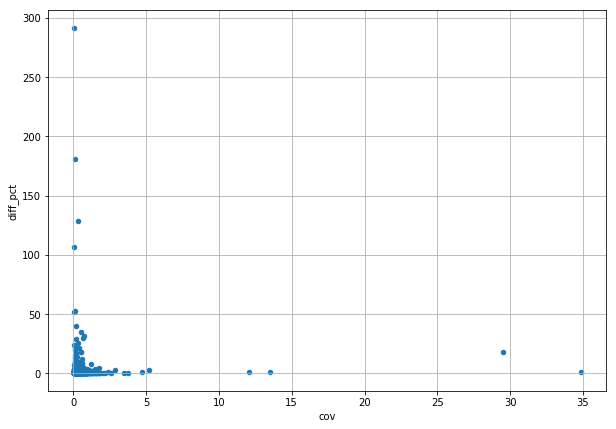

In [242]:
factor_cov(players)

the corr between cov and different percantage is:  -0.0119185397126


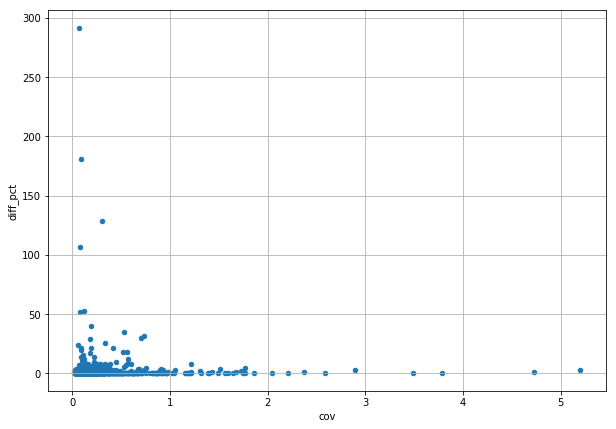

In [243]:
factor_cov(players_t)

data in range: 0.9309954751131222


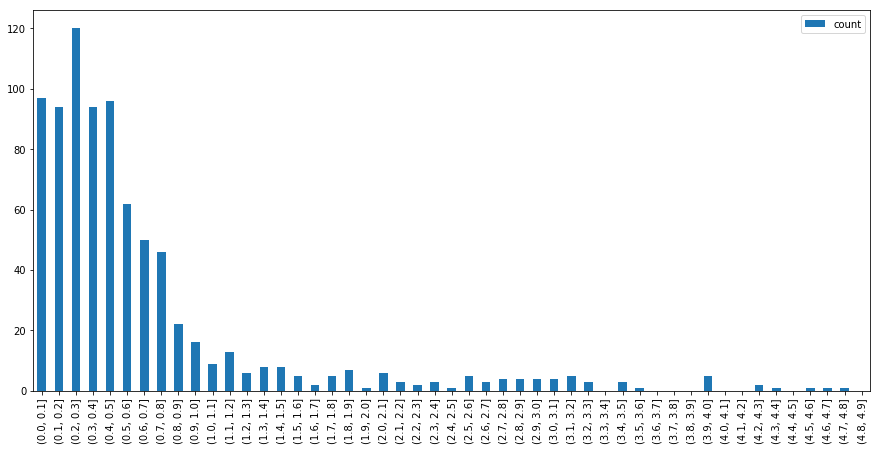

In [244]:
diff_distribution(players, 5, 0.1)

data in range: 0.9311926605504587


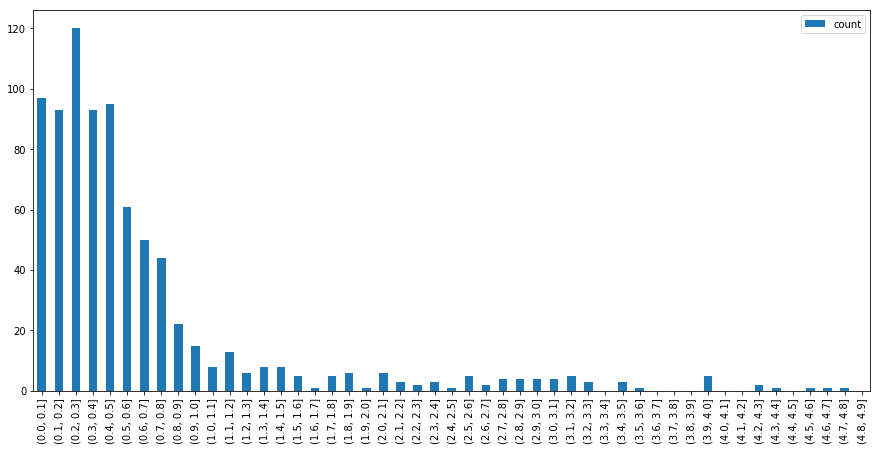

In [245]:
diff_distribution(players_t, 5, 0.1)

data in range: 0.9380733944954128


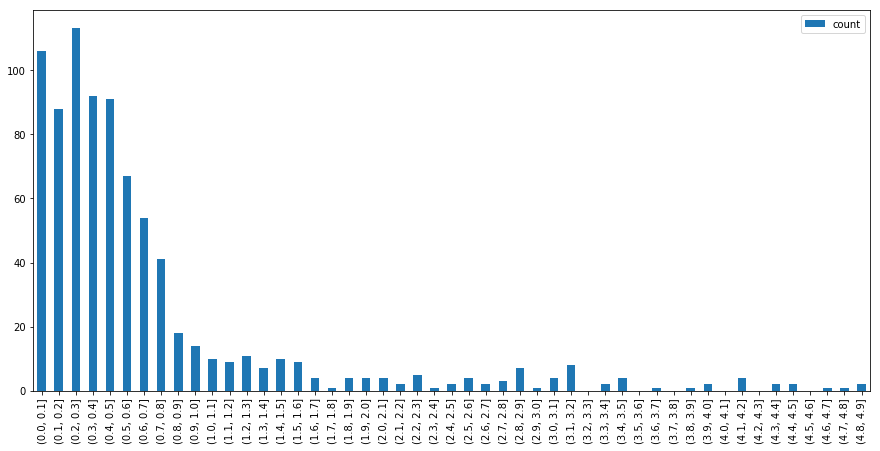

In [246]:
diff_distribution(players_t_1, 5, 0.1)